# Python HW4

*by: Yahui Zhao* 

In [74]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import pandas as pd
import numpy as np

## Question 1 Exploratory Data Analysis

In [75]:
import zipfile
import matplotlib.pyplot as plt

In [76]:
# load data
compustat_zip = zipfile.ZipFile("/Users/zhaoyahui/Downloads/compustat.zip")
compustat_data = pd.read_csv(compustat_zip.open('compustat.csv'), header = 0)

In [77]:
# get the data we need
data = compustat_data[['sic', 'datacqtr', 'cusip', 'cshoq', 'saleq', 'prccq']]
data.head()

,sic,datacqtr,cusip,cshoq,saleq,prccq
0,3089.0,1966Q1,000032102,0.219,NaN,NaN
1,3089.0,1966Q2,000032102,0.219,NaN,NaN
2,3089.0,1966Q3,000032102,0.219,NaN,NaN
3,3089.0,1966Q4,000032102,0.219,4.032,NaN
4,3089.0,1967Q1,000032102,0.277,NaN,NaN


In [78]:
# market cap
data.loc[:,"market_cap"] = data.loc[:,"prccq"] * data.loc[:,"cshoq"]
data.head()

/Users/zhaoyahui/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/zhaoyahui/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,sic,datacqtr,cusip,cshoq,saleq,prccq,market_cap
0,3089.0,1966Q1,000032102,0.219,NaN,NaN,NaN
1,3089.0,1966Q2,000032102,0.219,NaN,NaN,NaN
2,3089.0,1966Q3,000032102,0.219,NaN,NaN,NaN
3,3089.0,1966Q4,000032102,0.219,4.032,NaN,NaN
4,3089.0,1967Q1,000032102,0.277,NaN,NaN,NaN


In [79]:
# For saleq and market cap, compute: Time series mean, Time Series standard deviation etc
def aggregate_result(df):
    missing_num = df.isnull().sum()
    total = df.count()
    missing_ratio = missing_num / total
    return pd.Series([df.mean(), df.std(), missing_num, missing_ratio], index=['mean', 'standard deviation', 'count of missing values', 'ratio of missing values'])

# Aggregate the result
market_cap_result = aggregate_result(data['market_cap'])
saleq_result = aggregate_result(data['saleq'])
aggregate_result = pd.concat([market_cap_result, saleq_result], axis = 1)
aggregate_result

,0,1
mean,2057.473104,445.150664
standard deviation,13202.197457,2679.706576
count of missing values,468276.000000,269498.000000
ratio of missing values,0.348673,0.174794


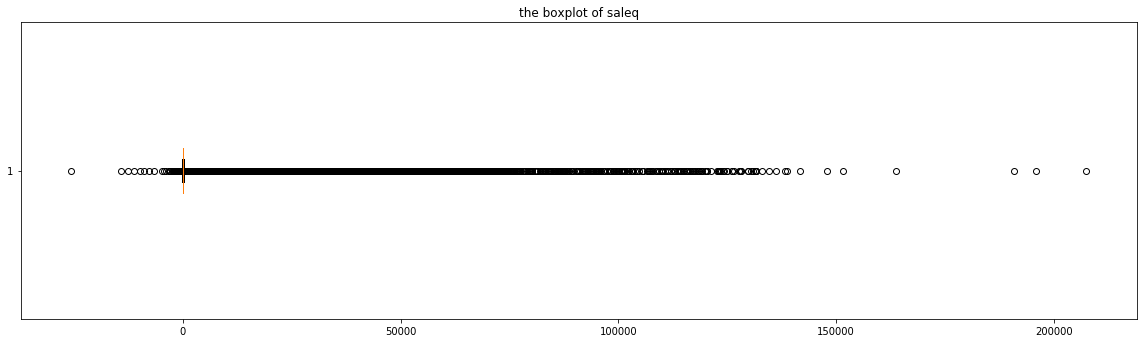

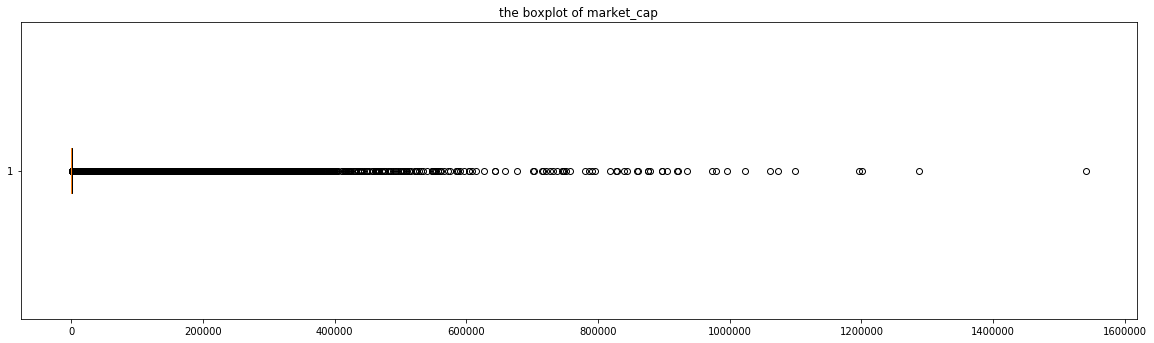

In [80]:
# outliers
plt.rcParams["figure.figsize"] = (20, 12)
figure1 = plt.figure().add_subplot(2, 1, 1)
figure1.boxplot(data["saleq"].dropna(), vert = False)
figure1.set_title("the boxplot of saleq")
figure2 = plt.figure().add_subplot(2, 1, 2)
figure2.boxplot(data["market_cap"].dropna(), vert = False)
figure2.set_title("the boxplot of market_cap")
plt.show()

I think there are some outliers by using the boxplot to detect it. I guess the reason is that the market variance is really big these days.

## Question 2 Compute Industry Concentration

In [81]:
# by looking at HHI index
data_HHI = data.loc[:, ["datacqtr", "market_cap", "sic"]].copy()
# drop the missing values
data_HHI = data_HHI.dropna()
# using a 2 digit SIC code
data_HHI["2d-sic"] = data_HHI["sic"] / 100
industry_total_cap = data_HHI.groupby(["2d-sic", "datacqtr"])["market_cap"].sum().reset_index()
data_HHI = pd.merge(data_HHI, industry_total_cap, on = ["2d-sic","datacqtr"])

data_HHI["HHI"] = (data_HHI['market_cap_x'] / data_HHI["market_cap_y"] * 100) ** 2
industry_HHI = data_HHI.groupby(["datacqtr","2d-sic"])["HHI"].sum()
industry_HHI.head()

datacqtr  2d-sic
1962Q1    45.12     10000.000000
          60.20       564.058299
1962Q2    40.11      3013.961261
          45.12     10000.000000
          60.20       543.295514
Name: HHI, dtype: float64

In [82]:
mean_HHI = industry_HHI.groupby("2d-sic").apply(np.mean)
mean_HHI = mean_HHI[mean_HHI < 10000]
mean_HHI.sort_values(ascending = False, inplace = True)
mean_HHI

2d-sic
34.51    9984.447643
40.13    9843.342743
27.32    9631.589490
37.20    9415.444759
81.11    9362.460875
            ...     
67.98     687.366624
49.31     508.413701
49.11     483.313013
60.20     311.314465
67.26     271.358670
Name: HHI, Length: 441, dtype: float64

In [83]:
# the top 4
HHI_index = pd.DataFrame(industry_HHI)
HHI_index.reset_index(inplace = True)

HHI_index1 = HHI_index[HHI_index["2d-sic"] == 34.51]
HHI_index2 = HHI_index[HHI_index["2d-sic"] == 40.13]
HHI_index3 = HHI_index[HHI_index["2d-sic"] == 27.32]
HHI_index4 = HHI_index[HHI_index["2d-sic"] == 37.20]

top_HHI = mean_HHI.head(4)
top_HHI

2d-sic
34.51    9984.447643
40.13    9843.342743
27.32    9631.589490
37.20    9415.444759
Name: HHI, dtype: float64

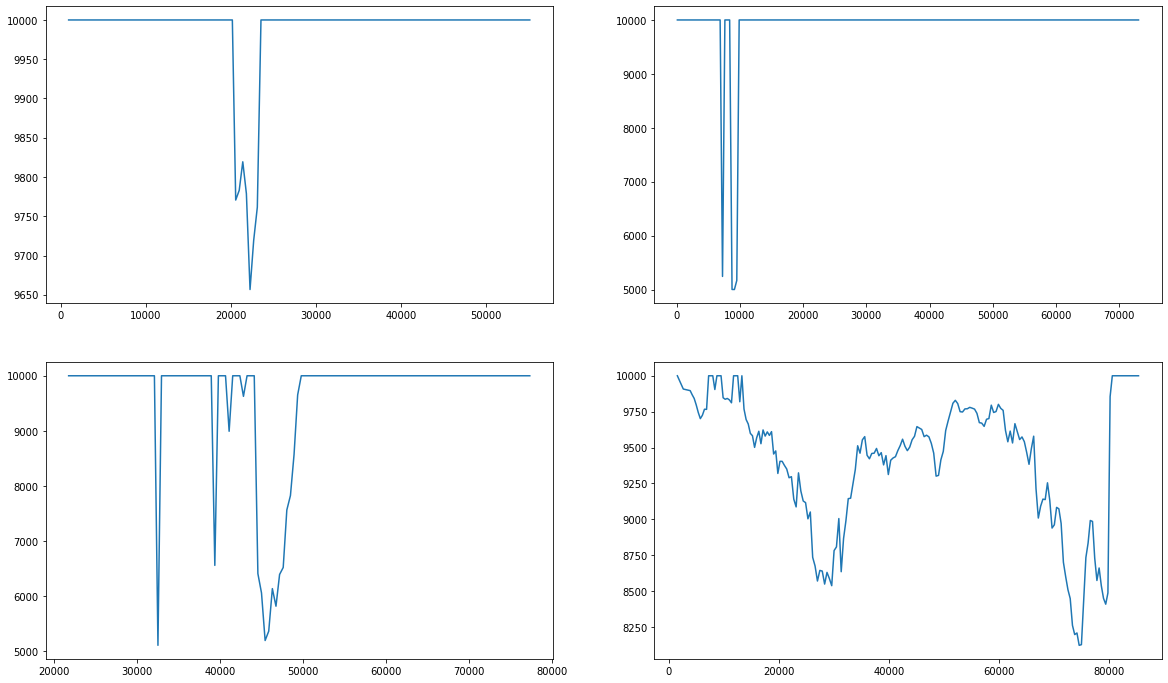

In [84]:
# Plot the time series pattern of HHI in 2 by 2 figure
plt.rcParams["figure.figsize"] = (20, 12)

ax1 = plt.subplot(2, 2, 1)
plt.plot(HHI_index1.index, HHI_index1["HHI"])

ax2 = plt.subplot(2, 2, 2)
plt.plot(HHI_index2.index, HHI_index2["HHI"])

ax3 = plt.subplot(2, 2, 3)
plt.plot(HHI_index3.index, HHI_index3["HHI"])

ax4 = plt.subplot(2, 2, 4)
plt.plot(HHI_index4.index, HHI_index4["HHI"])

plt.show()